使用sklearn实现超参数搜索

In [1]:
# 使用tf.keras搭建回归模型，数据集使用加利福尼亚的房价预测
#导入必要的库即版本

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
#import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd,sklearn,tf,keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 2.2.3
numpy 1.16.4
pandas 0.23.4
sklearn 0.19.2
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
# 导入数据
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [3]:
# 打印数据
import pprint

pprint.pprint(housing.data[:5])
pprint.pprint(housing.target[:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
# 拆分训练集、测试集、验证集
from sklearn.model_selection import train_test_split

# 默认按3：1的比例拆分
x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


### 数据归一化

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 训练机上获得均值和方差，测试集和验证集上用相同的均值和方差
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

### 构建模型

In [7]:
# RandomizedSearchCV
#1.转化为sklearn的model
#2.定义参数集合
#3.搜索参数
# API-keras-wrappers-scikit_learn-kerasregressor,将keras模型转换为sklearn封装
def build_model(hidden_layers=1, layer_size=30, learning_rate=3e-3):
    model =keras.models.Sequential()
    # 第一个需要添加input_shape
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# 使用earlystopping
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

history = sklearn_model.fit(x_train_scaled, y_train, epochs=100,
                 validation_data=(x_valid_scaled, y_valid),
                 callbacks=callbacks)


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 34us/sample - loss: 1.2894 - val_loss: 0.7499
Epoch 2/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.6596 - val_loss: 0.6656
Epoch 3/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5924 - val_loss: 0.6104
Epoch 4/100
11610/11610 [==============================] - 0s 24us/sample - loss: 0.5512 - val_loss: 0.5713
Epoch 5/100
11610/11610 [==============================] - 0s 22us/sample - loss: 0.5192 - val_loss: 0.5363
Epoch 6/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.4947 - val_loss: 0.5141
Epoch 7/100
11610/11610 [==============================] - 0s 23us/sample - loss: 0.4754 - val_loss: 0.4952
Epoch 8/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4664 - val_loss: 0.4821
Epoch 9/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.450

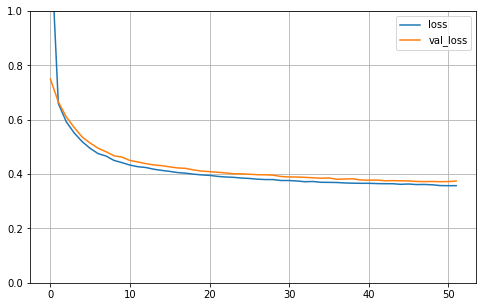

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [12]:
from scipy.stats import reciprocal
# f(x)=1/(x*log(b/a))   a<=x<=b

param_distribution = {
    'hidden_layers':[1,2,3,4],
    'layer_size':np.arange(1,100),
    'learning_rate':reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, 
                                      #参数分布
                                     param_distribution,
                                      # 从参数分布中生成多少参数集合
                                     n_iter=10,
                                      # 多少任务并行处理
                                     n_jobs=1)

random_search_cv.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks=callbacks)


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 44us/sample - loss: 1.7315 - val_loss: 0.8349
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.7473 - val_loss: 0.7272
Epoch 3/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6536 - val_loss: 0.6628
Epoch 4/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6108 - val_loss: 0.6288
Epoch 5/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.5784 - val_loss: 0.5992
Epoch 6/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5489 - val_loss: 0.5637
Epoch 7/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5266 - val_loss: 0.5442
Epoch 8/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5120 - val_loss: 0.5352
Epoch 9/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4979 - val_loss: 0.515

7740/7740 [==============================] - 0s 35us/sample - loss: 0.3633 - val_loss: 0.3779
Epoch 78/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3629 - val_loss: 0.3748
Epoch 79/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3625 - val_loss: 0.3737
Epoch 80/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3622 - val_loss: 0.3720
Epoch 81/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3619 - val_loss: 0.3728
Epoch 82/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3616 - val_loss: 0.3725
Epoch 83/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3605 - val_loss: 0.3708
Epoch 84/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3607 - val_loss: 0.3700
Epoch 85/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3605 - val_loss: 0.3711
Epoch 86/100
7740/7740 [==========================

Epoch 64/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3822 - val_loss: 0.3992
Epoch 65/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3755 - val_loss: 0.3807
Epoch 66/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3712 - val_loss: 0.4075
Epoch 67/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3689 - val_loss: 0.3807
Epoch 68/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3665 - val_loss: 0.4032
Epoch 69/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3662 - val_loss: 0.3817
Epoch 70/100
7740/7740 [==============================] - 0s 14us/sample - loss: 0.3632
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 40us/sample - loss: 1.6841 - val_loss: 0.8006
Epoch 2/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6615 - val_loss: 0.6993
Epoch 3/10

7740/7740 [==============================] - 0s 30us/sample - loss: 0.3439 - val_loss: 0.3766
Epoch 69/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3434 - val_loss: 0.3783
Epoch 70/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.3431 - val_loss: 0.3750
Epoch 71/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3428 - val_loss: 0.3755
Epoch 72/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3413 - val_loss: 0.3761
Epoch 73/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3422 - val_loss: 0.3734
Epoch 74/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3405 - val_loss: 0.3751
Epoch 75/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3398 - val_loss: 0.3724
Epoch 76/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3392 - val_loss: 0.3727
Epoch 77/100
7740/7740 [==========================

Epoch 55/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5873 - val_loss: 0.6169
Epoch 56/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5848 - val_loss: 0.6141
Epoch 57/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5823 - val_loss: 0.6115
Epoch 58/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5798 - val_loss: 0.6088
Epoch 59/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5774 - val_loss: 0.6062
Epoch 60/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5750 - val_loss: 0.6036
Epoch 61/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5727 - val_loss: 0.6011
Epoch 62/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5704 - val_loss: 0.5989
Epoch 63/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5682 - val_loss: 0.5965
Epoch 64/100
7740/7740 [=============

Epoch 30/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6185 - val_loss: 0.6665
Epoch 31/100
7740/7740 [==============================] - ETA: 0s - loss: 0.610 - 0s 32us/sample - loss: 0.6147 - val_loss: 0.6625
Epoch 32/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6110 - val_loss: 0.6588
Epoch 33/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6075 - val_loss: 0.6551
Epoch 34/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6040 - val_loss: 0.6515
Epoch 35/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6007 - val_loss: 0.6480
Epoch 36/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5975 - val_loss: 0.6446
Epoch 37/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5943 - val_loss: 0.6413
Epoch 38/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5913 - val_loss: 0.6381
Epoch 39/100


7740/7740 [==============================] - 0s 29us/sample - loss: 1.6206 - val_loss: 1.5392
Epoch 5/100
7740/7740 [==============================] - 0s 30us/sample - loss: 1.3217 - val_loss: 1.2897
Epoch 6/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.1199 - val_loss: 1.1199
Epoch 7/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.9776 - val_loss: 0.9994
Epoch 8/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.8766 - val_loss: 0.9126
Epoch 9/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.8041 - val_loss: 0.8495
Epoch 10/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.7517 - val_loss: 0.8037
Epoch 11/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.7139 - val_loss: 0.7710
Epoch 12/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.6866 - val_loss: 0.7472
Epoch 13/100
7740/7740 [==============================]

7740/7740 [==============================] - 0s 28us/sample - loss: 0.4702 - val_loss: 0.5207
Epoch 81/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4690 - val_loss: 0.5193
Epoch 82/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4678 - val_loss: 0.5179
Epoch 83/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4666 - val_loss: 0.5166
Epoch 84/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4655 - val_loss: 0.5153
Epoch 85/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4644 - val_loss: 0.5139
Epoch 86/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4633 - val_loss: 0.5127
Epoch 87/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4622 - val_loss: 0.5114
Epoch 88/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4612 - val_loss: 0.5101
Epoch 89/100
7740/7740 [==========================

Epoch 55/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5812 - val_loss: 0.6091
Epoch 56/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5788 - val_loss: 0.6064
Epoch 57/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5765 - val_loss: 0.6040
Epoch 58/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5743 - val_loss: 0.6015
Epoch 59/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5720 - val_loss: 0.5990
Epoch 60/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5699 - val_loss: 0.5969
Epoch 61/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5678 - val_loss: 0.5945
Epoch 62/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5657 - val_loss: 0.5921
Epoch 63/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5637 - val_loss: 0.5899
Epoch 64/100
7740/7740 [=============

7740/7740 [==============================] - 0s 28us/sample - loss: 0.6380 - val_loss: 0.6906
Epoch 30/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6339 - val_loss: 0.6861
Epoch 31/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6297 - val_loss: 0.6817
Epoch 32/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6258 - val_loss: 0.6774
Epoch 33/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6219 - val_loss: 0.6731
Epoch 34/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6181 - val_loss: 0.6690
Epoch 35/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6144 - val_loss: 0.6649
Epoch 36/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6108 - val_loss: 0.6609
Epoch 37/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6072 - val_loss: 0.6570
Epoch 38/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 30us/sample - loss: 2.1239 - val_loss: 2.0381
Epoch 4/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.6553 - val_loss: 1.6944
Epoch 5/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.3875 - val_loss: 1.4817
Epoch 6/100
7740/7740 [==============================] - 0s 30us/sample - loss: 1.2179 - val_loss: 1.3302
Epoch 7/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.0970 - val_loss: 1.2125
Epoch 8/100
7740/7740 [==============================] - 0s 30us/sample - loss: 1.0054 - val_loss: 1.1168
Epoch 9/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.9338 - val_loss: 1.0388
Epoch 10/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.8767 - val_loss: 0.9749
Epoch 11/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.8310 - val_loss: 0.9230
Epoch 12/100
7740/7740 [==============================] 

7740/7740 [==============================] - 0s 32us/sample - loss: 0.5027 - val_loss: 0.5531
Epoch 80/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5013 - val_loss: 0.5514
Epoch 81/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.5000 - val_loss: 0.5498
Epoch 82/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4987 - val_loss: 0.5483
Epoch 83/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4973 - val_loss: 0.5468
Epoch 84/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4961 - val_loss: 0.5452
Epoch 85/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4948 - val_loss: 0.5437
Epoch 86/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4935 - val_loss: 0.5422
Epoch 87/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4922 - val_loss: 0.5408
Epoch 88/100
7740/7740 [==========================

Epoch 54/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.4107 - val_loss: 0.4209
Epoch 55/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4089 - val_loss: 0.4197
Epoch 56/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4074 - val_loss: 0.4177
Epoch 57/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4062 - val_loss: 0.4163
Epoch 58/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4046 - val_loss: 0.4146
Epoch 59/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4031 - val_loss: 0.4138
Epoch 60/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4019 - val_loss: 0.4117
Epoch 61/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4006 - val_loss: 0.4105
Epoch 62/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3992 - val_loss: 0.4092
Epoch 63/100
7740/7740 [=============

Epoch 29/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4806 - val_loss: 0.5178
Epoch 30/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4761 - val_loss: 0.5126
Epoch 31/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4719 - val_loss: 0.5082
Epoch 32/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4680 - val_loss: 0.5036
Epoch 33/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4641 - val_loss: 0.4993
Epoch 34/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4604 - val_loss: 0.4951
Epoch 35/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4568 - val_loss: 0.4911
Epoch 36/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4535 - val_loss: 0.4871
Epoch 37/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4502 - val_loss: 0.4834
Epoch 38/100
7740/7740 [=============

7740/7740 [==============================] - 0s 40us/sample - loss: 1.1086 - val_loss: 1.0744
Epoch 4/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.9488 - val_loss: 0.9453
Epoch 5/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.8454 - val_loss: 0.8598
Epoch 6/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.7739 - val_loss: 0.7992
Epoch 7/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.7222 - val_loss: 0.7560
Epoch 8/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6831 - val_loss: 0.7237
Epoch 9/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.6529 - val_loss: 0.6983
Epoch 10/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.6286 - val_loss: 0.6766
Epoch 11/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6082 - val_loss: 0.6585
Epoch 12/100
7740/7740 [==============================] 

7740/7740 [==============================] - 0s 40us/sample - loss: 0.3627 - val_loss: 0.3997
Epoch 80/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.3618 - val_loss: 0.3988
Epoch 81/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3611 - val_loss: 0.3979
Epoch 82/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3602 - val_loss: 0.3973
Epoch 83/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3594 - val_loss: 0.3960
Epoch 84/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.3585 - val_loss: 0.3958
Epoch 85/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3578 - val_loss: 0.3955
Epoch 86/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3573 - val_loss: 0.3946
Epoch 87/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3565 - val_loss: 0.3928
Epoch 88/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 29us/sample - loss: 0.3128 - val_loss: 0.3261
Epoch 54/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3115 - val_loss: 0.3237
Epoch 55/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3109 - val_loss: 0.3299
Epoch 56/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3102 - val_loss: 0.3232
Epoch 57/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3089 - val_loss: 0.3222
Epoch 58/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3079 - val_loss: 0.3372
Epoch 59/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3073 - val_loss: 0.3229
Epoch 60/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3074 - val_loss: 0.3261
Epoch 61/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3055 - val_loss: 0.3193
Epoch 62/100
7740/7740 [==========================

Epoch 8/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4115 - val_loss: 0.4543
Epoch 9/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4033 - val_loss: 0.4391
Epoch 10/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3949 - val_loss: 0.4281
Epoch 11/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3885 - val_loss: 0.4219
Epoch 12/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3825 - val_loss: 0.4165
Epoch 13/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3771 - val_loss: 0.4107
Epoch 14/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3733 - val_loss: 0.4087
Epoch 15/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.3690 - val_loss: 0.4038
Epoch 16/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3653 - val_loss: 0.3979
Epoch 17/100
7740/7740 [===============

7740/7740 [==============================] - 0s 28us/sample - loss: 1.3105 - val_loss: 1.3830
Epoch 9/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.3104 - val_loss: 1.3833
Epoch 10/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.3104 - val_loss: 1.3831
Epoch 11/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.3104 - val_loss: 1.3830
Epoch 12/100
7740/7740 [==============================] - 0s 14us/sample - loss: 1.3103
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 41us/sample - loss: 3.2710 - val_loss: 2.1736
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 1.6424 - val_loss: 1.5396
Epoch 3/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.3663 - val_loss: 1.4187
Epoch 4/100
7740/7740 [==============================] - 0s 28us/sample - loss: 1.3188 - val_loss: 1.3937
Epoch 5/100
7740/7740 [===

7740/7740 [==============================] - 0s 27us/sample - loss: 0.5064 - val_loss: 0.5276
Epoch 57/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5047 - val_loss: 0.5257
Epoch 58/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5031 - val_loss: 0.5240
Epoch 59/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5014 - val_loss: 0.5224
Epoch 60/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.4999 - val_loss: 0.5207
Epoch 61/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4984 - val_loss: 0.5190
Epoch 62/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4969 - val_loss: 0.5172
Epoch 63/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4954 - val_loss: 0.5155
Epoch 64/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4940 - val_loss: 0.5140
Epoch 65/100
7740/7740 [==========================

Epoch 31/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5474 - val_loss: 0.5999
Epoch 32/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5442 - val_loss: 0.5965
Epoch 33/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5412 - val_loss: 0.5930
Epoch 34/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5384 - val_loss: 0.5898
Epoch 35/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5357 - val_loss: 0.5868
Epoch 36/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5331 - val_loss: 0.5839
Epoch 37/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5305 - val_loss: 0.5811
Epoch 38/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5281 - val_loss: 0.5784
Epoch 39/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5258 - val_loss: 0.5759
Epoch 40/100
7740/7740 [=============

Epoch 6/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.9984 - val_loss: 1.0027
Epoch 7/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.8800 - val_loss: 0.9044
Epoch 8/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.8040 - val_loss: 0.8420
Epoch 9/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.7536 - val_loss: 0.8011
Epoch 10/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.7193 - val_loss: 0.7733
Epoch 11/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6952 - val_loss: 0.7538
Epoch 12/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.6776 - val_loss: 0.7394
Epoch 13/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6642 - val_loss: 0.7281
Epoch 14/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6536 - val_loss: 0.7190
Epoch 15/100
7740/7740 [=================

7740/7740 [==============================] - 0s 26us/sample - loss: 0.4793 - val_loss: 0.5336
Epoch 83/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4784 - val_loss: 0.5326
Epoch 84/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4776 - val_loss: 0.5316
Epoch 85/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4767 - val_loss: 0.5306
Epoch 86/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4759 - val_loss: 0.5296
Epoch 87/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4750 - val_loss: 0.5287
Epoch 88/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4742 - val_loss: 0.5277
Epoch 89/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4734 - val_loss: 0.5268
Epoch 90/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4726 - val_loss: 0.5260
Epoch 91/100
7740/7740 [==========================

Epoch 57/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4596 - val_loss: 0.4814
Epoch 58/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4579 - val_loss: 0.4801
Epoch 59/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4565 - val_loss: 0.4778
Epoch 60/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4549 - val_loss: 0.4762
Epoch 61/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4533 - val_loss: 0.4743
Epoch 62/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4519 - val_loss: 0.4730
Epoch 63/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4504 - val_loss: 0.4714
Epoch 64/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4491 - val_loss: 0.4697
Epoch 65/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4476 - val_loss: 0.4681
Epoch 66/100
7740/7740 [=============

Epoch 32/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5087 - val_loss: 0.5474
Epoch 33/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5053 - val_loss: 0.5433
Epoch 34/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5019 - val_loss: 0.5396
Epoch 35/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4989 - val_loss: 0.5360
Epoch 36/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4960 - val_loss: 0.5325
Epoch 37/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4931 - val_loss: 0.5293
Epoch 38/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4904 - val_loss: 0.5261
Epoch 39/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4877 - val_loss: 0.5232
Epoch 40/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4853 - val_loss: 0.5202
Epoch 41/100
7740/7740 [=============

Epoch 7/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.7356 - val_loss: 0.7958
Epoch 8/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.7165 - val_loss: 0.7782
Epoch 9/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.7006 - val_loss: 0.7633
Epoch 10/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6865 - val_loss: 0.7498
Epoch 11/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6735 - val_loss: 0.7368
Epoch 12/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6618 - val_loss: 0.7254
Epoch 13/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.6508 - val_loss: 0.7146
Epoch 14/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6404 - val_loss: 0.7042
Epoch 15/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6305 - val_loss: 0.6947
Epoch 16/100
7740/7740 [================

7740/7740 [==============================] - 0s 30us/sample - loss: 0.4099 - val_loss: 0.4502
Epoch 84/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4089 - val_loss: 0.4497
Epoch 85/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4081 - val_loss: 0.4482
Epoch 86/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.4071 - val_loss: 0.4477
Epoch 87/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4064 - val_loss: 0.4462
Epoch 88/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4055 - val_loss: 0.4452
Epoch 89/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4047 - val_loss: 0.4445
Epoch 90/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4040 - val_loss: 0.4437
Epoch 91/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4032 - val_loss: 0.4430
Epoch 92/100
7740/7740 [==========================

Epoch 58/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3847 - val_loss: 0.3979
Epoch 59/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3830 - val_loss: 0.3961
Epoch 60/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3811 - val_loss: 0.3951
Epoch 61/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3795 - val_loss: 0.3933
Epoch 62/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3780 - val_loss: 0.3919
Epoch 63/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3764 - val_loss: 0.3901
Epoch 64/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3756 - val_loss: 0.3883
Epoch 65/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3741 - val_loss: 0.3873
Epoch 66/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3727 - val_loss: 0.3866
Epoch 67/100
7740/7740 [=============

Epoch 33/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4306 - val_loss: 0.4522
Epoch 34/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4275 - val_loss: 0.4493
Epoch 35/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4247 - val_loss: 0.4459
Epoch 36/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4220 - val_loss: 0.4434
Epoch 37/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4195 - val_loss: 0.4403
Epoch 38/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4171 - val_loss: 0.4378
Epoch 39/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4144 - val_loss: 0.4348
Epoch 40/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4122 - val_loss: 0.4330
Epoch 41/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4101 - val_loss: 0.4296
Epoch 42/100
7740/7740 [=============

Epoch 8/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.6351 - val_loss: 0.7046
Epoch 9/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6188 - val_loss: 0.6878
Epoch 10/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.6039 - val_loss: 0.6718
Epoch 11/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5902 - val_loss: 0.6575
Epoch 12/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5772 - val_loss: 0.6432
Epoch 13/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5659 - val_loss: 0.6310
Epoch 14/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5552 - val_loss: 0.6186
Epoch 15/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5450 - val_loss: 0.6091
Epoch 16/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5361 - val_loss: 0.5974
Epoch 17/100
7740/7740 [===============

7740/7740 [==============================] - 0s 35us/sample - loss: 0.3381 - val_loss: 0.3731
Epoch 85/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.3374 - val_loss: 0.3733
Epoch 86/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3366 - val_loss: 0.3732
Epoch 87/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3360 - val_loss: 0.3719
Epoch 88/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3348 - val_loss: 0.3726
Epoch 89/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3345 - val_loss: 0.3698
Epoch 90/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3336 - val_loss: 0.3694
Epoch 91/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3327 - val_loss: 0.3696
Epoch 92/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.3321 - val_loss: 0.3680
Epoch 93/100
7740/7740 [==========================

Epoch 59/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3282 - val_loss: 0.3451
Epoch 60/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3265 - val_loss: 0.3436
Epoch 61/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3248 - val_loss: 0.3490
Epoch 62/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3244 - val_loss: 0.3388
Epoch 63/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3231 - val_loss: 0.3399
Epoch 64/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.3231 - val_loss: 0.3383
Epoch 65/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3223 - val_loss: 0.3385
Epoch 66/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3202 - val_loss: 0.3344
Epoch 67/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.3198 - val_loss: 0.3409
Epoch 68/100
7740/7740 [=============

7740/7740 [==============================] - 0s 31us/sample - loss: 0.3366 - val_loss: 0.3532
Epoch 63/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.3356 - val_loss: 0.3512
Epoch 64/100
7740/7740 [==============================] - 0s 13us/sample - loss: 0.3330
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 54us/sample - loss: 2.4691 - val_loss: 1.0695
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.7408 - val_loss: 0.6888
Epoch 3/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.6149 - val_loss: 0.6503
Epoch 4/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5818 - val_loss: 0.6216
Epoch 5/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5564 - val_loss: 0.5955
Epoch 6/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.5344 - val_loss: 0.5733
Epoch 7/100
7740/7740 [====

Epoch 73/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.2835 - val_loss: 0.3256
Epoch 74/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.2849 - val_loss: 0.3237
Epoch 75/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.2832 - val_loss: 0.3259
Epoch 76/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.2826 - val_loss: 0.3280
Epoch 77/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.2822 - val_loss: 0.3240
Epoch 78/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.2824 - val_loss: 0.3242
Epoch 79/100
7740/7740 [==============================] - 0s 12us/sample - loss: 0.28170s - loss: 0.279
Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 35us/sample - loss: 1.2397 - val_loss: 0.7082
Epoch 2/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.6158 - val_lo

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000028694396DD8>,
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'hidden_layers': [1, 2, 3, 4], 'layer_size': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028698A162E8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [13]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 3, 'layer_size': 26, 'learning_rate': 0.002570069323321298}
-0.32869580000459275


In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

In [11]:
from scipy.stats import reciprocal
reciprocal.rvs(1e-4, 1e-2,size=10)

array([0.00226314, 0.0059983 , 0.00019297, 0.00084966, 0.00541417,
       0.00229253, 0.0094598 , 0.00104767, 0.00023446, 0.00706425])